First we have to download all requirements package to use anomalib

In [1]:
!pip install anomalib
!pip install qdrant-client
!pip install torchmetrics
!pip install kornia
!pip install dotenv
!pip install lightning
!pip install FrEIA
!pip install open-clip-torch
!pip install openvino

  Using cached qdrant_client-1.13.2-py3-none-any.whl.metadata (10 kB)
  Using cached grpcio_tools-1.70.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (5.3 kB)
  Using cached portalocker-2.10.1-py3-none-any.whl.metadata (8.5 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 306.6/306.6 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 73.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319.7/319.7 kB 29.7 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 4.25.6
    Uninstalling protobuf-4.25.6:
      Successfully uninstalled protobuf-4.25.6
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 927.3/927.3 kB 25.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 110.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 84.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
!pip uninstall matplotlib
!pip install matplotlib==3.7.0

Found existing installation: matplotlib 3.10.0
Uninstalling matplotlib-3.10.0:
  Would remove:
    /usr/local/lib/python3.11/dist-packages/matplotlib-3.10.0.dist-info/*
    /usr/local/lib/python3.11/dist-packages/matplotlib/*
    /usr/local/lib/python3.11/dist-packages/mpl_toolkits/axes_grid1/*
    /usr/local/lib/python3.11/dist-packages/mpl_toolkits/axisartist/*
    /usr/local/lib/python3.11/dist-packages/mpl_toolkits/mplot3d/*
    /usr/local/lib/python3.11/dist-packages/pylab.py
Proceed (Y/n)? y
Y
  Successfully uninstalled matplotlib-3.10.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 87.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 1.38.0 requires matplotlib>=3.7.1, but you have matplotlib 3.7.0 which is incompatible.
plotnine 0.14.5 requires matplotlib>=3.8.0, but you have matplotlib 3.7.0 which is incompatible.


Import libraries

In [2]:
import os
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torchvision.transforms import ToPILImage
from anomalib.metrics import AUROC
import torch
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

from anomalib.data import MVTec
from anomalib.engine import Engine
from anomalib.models import Patchcore, EfficientAd
from anomalib.utils.visualization import ImageResult
from anomalib.data.utils import read_image

from qdrant_client import QdrantClient
from qdrant_client.models import Distance, VectorParams

Data downloading

In [3]:
categories = ["tile", "leather", "grid"]
datamodules = {cat: MVTec(category=cat, num_workers=0) for cat in categories}

In [4]:
for cat, datamodule in datamodules.items():
    datamodule.prepare_data()
    datamodule.setup()
i, data = next(enumerate(datamodules["tile"].val_dataloader()))

mvtec: 5.26GB [04:10, 21.0MB/s]                            


1

intialize models

In [5]:
patchcore_model = Patchcore(pre_trained=True)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/276M [00:00<?, ?B/s]

In [6]:
efficientad_model = EfficientAd()

It is recommend that you have gpu to train the model or else it will take forever.

In [7]:
print("CUDA Available:", torch.cuda.is_available())
print("Number of GPUs:", torch.cuda.device_count())

CUDA Available: True
Number of GPUs: 1


Training

In [8]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
%matplotlib inline
# Initialize engine

auroc_results = {}
y_label = {}
y_score = {}
for model_name, model in [("Patchcore", patchcore_model)]:
    auroc_results[model_name] = {}
    for cat, datamodule in datamodules.items():
        y_label[cat] = []
        y_score[cat] = []
        print(f"Training {model_name} for {cat}")
        engine = Engine(
            devices=1,  # Number of GPUs to use
            accelerator="gpu" if torch.cuda.is_available() else "cpu",
            max_epochs=3,
            # val_check_interval=1.0,  # Enable validation after every epoch
        )
        engine.fit(model=model, datamodule=datamodule)

        print(f"Evaluating {model_name} for {cat}")

        test_results = engine.test(
            model=model,
            datamodule=datamodule,
            ckpt_path=f"/content/results/{model_name}/MVTec/{cat}/latest/weights/lightning/model.ckpt"
        )

        # Extract AUROC Score
        auroc_score = test_results[0]["image_AUROC"]
        auroc_results[model_name][cat] = auroc_score
        predictions = engine.predict(
            datamodule=datamodule,
            model=model,
            ckpt_path=f"/content/results/{model_name}/MVTec/{cat}/latest/weights/lightning/model.ckpt"
        )


        for batch in predictions:
          y_label[cat].extend(batch['label'].numpy())
          y_score[cat].extend(batch['pred_scores'].numpy())
        print(f"{model_name} AUROC for {cat}: {auroc_score:.4f}")

Training Patchcore for tile


INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/core/optimizer.py:183: `LightningModule.configure_optimizers` returned `None`, this fit will run with no optimizer
INFO: 
  | Name                  | Type                     | Params | Mode 
---------------------------------------------------------------------------
0 | model                 | PatchcoreModel           | 24.9 M | train
1 | _transform            | Compose                  | 0      | train
2 | normalization_metric

Training: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/lightning/pytorch/loops/optimization/automatic.py:134: `training_step` returned `None`. If this was on purpose, ignore this warning...


Validation: |          | 0/? [00:00<?, ?it/s]



Selecting Coreset Indices.:   0%|          | 0/18032 [00:00<?, ?it/s]

Selecting Coreset Indices.:   0%|          | 1/18032 [00:00<42:18,  7.10it/s]

Selecting Coreset Indices.:   0%|          | 14/18032 [00:00<04:23, 68.43it/s]

Selecting Coreset Indices.:   0%|          | 35/18032 [00:00<02:23, 125.18it/s]

Selecting Coreset Indices.:   0%|          | 56/18032 [00:00<01:56, 154.40it/s]

Selecting Coreset Indices.:   0%|          | 77/18032 [00:00<01:44, 171.05it/s]

Selecting Coreset Indices.:   1%|          | 98/18032 [00:00<01:38, 181.86it/s]

Selecting Coreset Indices.:   1%|          | 119/18032 [00:00<01:34, 188.66it/s]

Selecting Coreset Indices.:   1%|          | 139/18032 [00:00<01:33, 192.03it/s]

Selecting Coreset Indices.:   1%|          | 160/18032 [00:00<01:31, 194.84it/s]

Selecting Coreset Indices.:   1%|          | 181/18032 [00:01<01:30, 197.08it/s]

Selecting Coreset Indices.:   1%|          | 202/18032 [00:01<01:29, 198.69it/s]

Selecting Coreset Indices.:   1%| 

Evaluating Patchcore for tile


INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: Loaded model weights from the checkpoint at /content/results/Patchcore/MVTec/tile/v0/weights/lightning/model.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Loaded model weights from the checkpoint at /content/results/Patchcore/MVTec/tile/v0/weights/lightning/model.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        image_AUROC        │     0.988095223903656     │
│       image_F1Score       │    0.9818181991577148     │
│        pixel_AUROC        │    0.9482614994049072     │
│       pixel_F1Score       │    0.6212415099143982     │
└───────────────────────────┴───────────────────────────┘

INFO: Restoring states from the checkpoint path at /content/results/Patchcore/MVTec/tile/v0/weights/lightning/model.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/results/Patchcore/MVTec/tile/v0/weights/lightning/model.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: Loaded model weights from the checkpoint at /content/results/Patchcore/MVTec/tile/v0/weights/lightning/model.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Loaded model weights from the checkpoint at /content/results/Patchcore/MVTec/tile/v0/weights/lightning/model.ckpt


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Patchcore AUROC for tile: 0.9881
Training Patchcore for leather


/usr/local/lib/python3.11/dist-packages/lightning/pytorch/core/optimizer.py:183: `LightningModule.configure_optimizers` returned `None`, this fit will run with no optimizer
INFO: 
  | Name                               | Type                     | Params | Mode 
----------------------------------------------------------------------------------------
0 | model                              | PatchcoreModel           | 24.9 M | train
1 | _transform                         | Compose                  | 0      | train
2 | normalization_metrics              | MetricCollection         | 0      | train
3 | image_threshold                    | F1AdaptiveThreshold      | 0      | train
4 | pixel_threshold                    | F1AdaptiveThreshold      | 0      | train
5 | image_metrics                      | AnomalibMetricCollection | 0      | train
6 | pixel_metrics                      | AnomalibMetricCollection | 0      | train
7 | box_scores_normalization_metrics   | MinMax                   |

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=1` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=1` reached.
/usr/local/lib/python3.11/dist-packages/anomalib/engine/engine.py:391: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file.

Evaluating Patchcore for leather


INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: Loaded model weights from the checkpoint at /content/results/Patchcore/MVTec/leather/v0/weights/lightning/model.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Loaded model weights from the checkpoint at /content/results/Patchcore/MVTec/leather/v0/weights/lightning/model.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        image_AUROC        │    0.7170515656471252     │
│       image_F1Score       │    0.8465116024017334     │
│        pixel_AUROC        │    0.8996353149414062     │
│       pixel_F1Score       │    0.29745933413505554    │
└───────────────────────────┴───────────────────────────┘

INFO: Restoring states from the checkpoint path at /content/results/Patchcore/MVTec/leather/v0/weights/lightning/model.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/results/Patchcore/MVTec/leather/v0/weights/lightning/model.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: Loaded model weights from the checkpoint at /content/results/Patchcore/MVTec/leather/v0/weights/lightning/model.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Loaded model weights from the checkpoint at /content/results/Patchcore/MVTec/leather/v0/weights/lightning/model.ckpt


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Patchcore AUROC for leather: 0.7171
Training Patchcore for grid


/usr/local/lib/python3.11/dist-packages/lightning/pytorch/core/optimizer.py:183: `LightningModule.configure_optimizers` returned `None`, this fit will run with no optimizer
INFO: 
  | Name                               | Type                     | Params | Mode 
----------------------------------------------------------------------------------------
0 | model                              | PatchcoreModel           | 24.9 M | train
1 | _transform                         | Compose                  | 0      | train
2 | normalization_metrics              | MetricCollection         | 0      | train
3 | image_threshold                    | F1AdaptiveThreshold      | 0      | train
4 | pixel_threshold                    | F1AdaptiveThreshold      | 0      | train
5 | image_metrics                      | AnomalibMetricCollection | 0      | train
6 | pixel_metrics                      | AnomalibMetricCollection | 0      | train
7 | box_scores_normalization_metrics   | MinMax                   |

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=1` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=1` reached.
/usr/local/lib/python3.11/dist-packages/anomalib/engine/engine.py:391: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file.

Evaluating Patchcore for grid


INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: Loaded model weights from the checkpoint at /content/results/Patchcore/MVTec/grid/v0/weights/lightning/model.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Loaded model weights from the checkpoint at /content/results/Patchcore/MVTec/grid/v0/weights/lightning/model.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        image_AUROC        │    0.8020049929618835     │
│       image_F1Score       │    0.8620689511299133     │
│        pixel_AUROC        │    0.2660142481327057     │
│       pixel_F1Score       │   0.016547653824090958    │
└───────────────────────────┴───────────────────────────┘

INFO: Restoring states from the checkpoint path at /content/results/Patchcore/MVTec/grid/v0/weights/lightning/model.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/results/Patchcore/MVTec/grid/v0/weights/lightning/model.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: Loaded model weights from the checkpoint at /content/results/Patchcore/MVTec/grid/v0/weights/lightning/model.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Loaded model weights from the checkpoint at /content/results/Patchcore/MVTec/grid/v0/weights/lightning/model.ckpt


Predicting: |          | 0/? [00:00<?, ?it/s]

Patchcore AUROC for grid: 0.8020


We train model on 3 categories (Title, leather, Grid)
In the process of training you will see Coreset Indices Selecting. This process is the greedy coreset subsampling method that model will select a subset of important features as reference for anomaly detection.

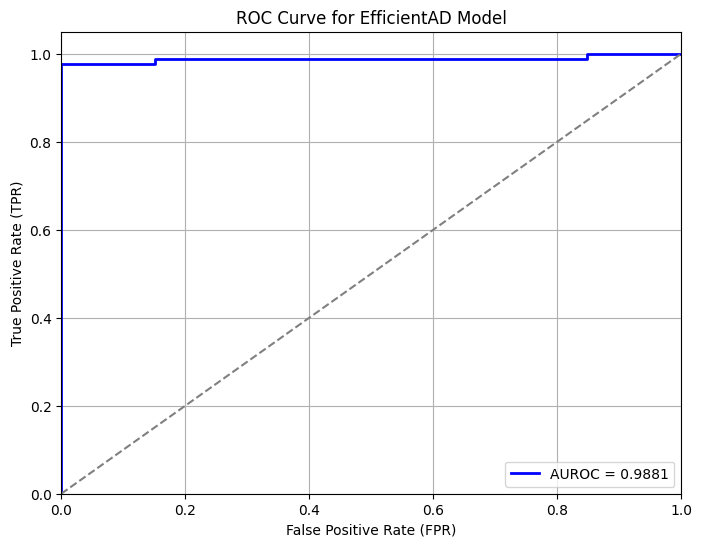

<Figure size 640x480 with 0 Axes>

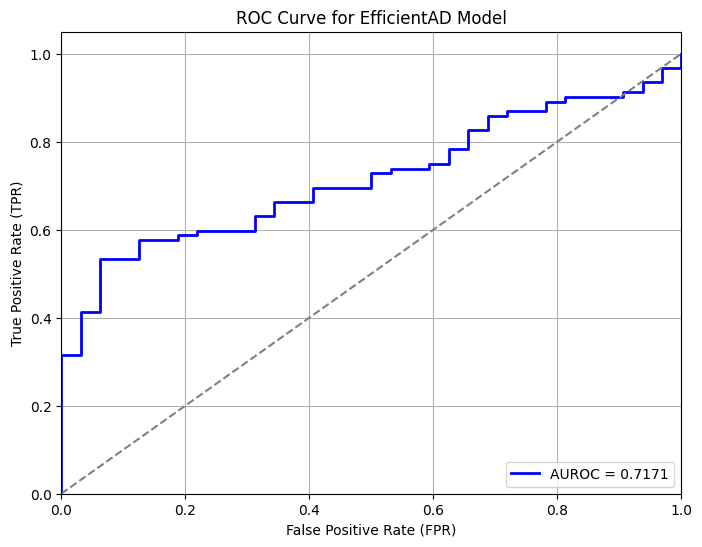

<Figure size 640x480 with 0 Axes>

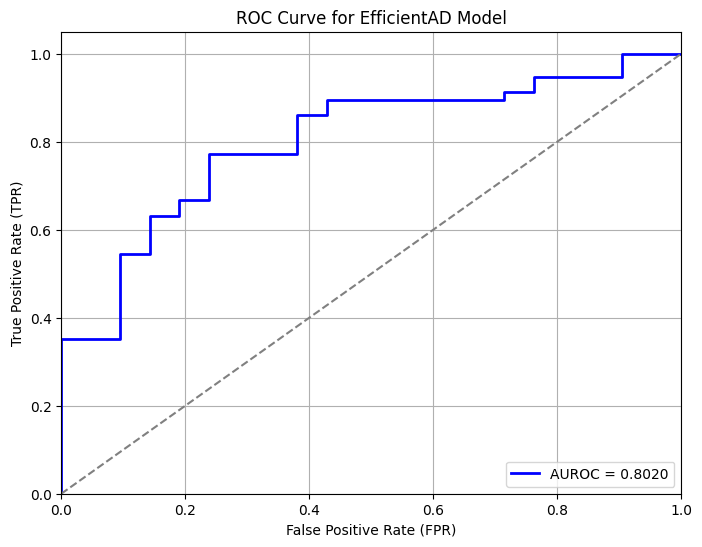

<Figure size 640x480 with 0 Axes>

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

for cat in categories:
  y_true_tensor = torch.tensor(y_label[cat])
  y_scores_tensor = torch.tensor(y_score[cat])
  auroc_score = AUROC()(y_scores_tensor, y_true_tensor)
  fpr, tpr, _ = roc_curve(y_label[cat], y_score[cat])
  roc_auc = auc(fpr, tpr)
  # Plot ROC Curve
  plt.figure(figsize=(8, 6))
  plt.plot(fpr, tpr, color="blue", lw=2, label=f"AUROC = {roc_auc:.4f}")
  plt.plot([0, 1], [0, 1], color="gray", linestyle="--")  # Random chance line
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel("False Positive Rate (FPR)")
  plt.ylabel("True Positive Rate (TPR)")
  plt.title("ROC Curve for EfficientAD Model")
  plt.legend(loc="lower right")
  plt.grid()
  plt.show()
  plt.clf()

We can see model work best when detecting tile then grid and finally leather

In [17]:
categories = ["tile", "leather", "grid"]
datamodules = {cat: MVTec(category=cat, num_workers=0, train_batch_size=1) for cat in categories}

In [18]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
%matplotlib inline
# Initialize engine

auroc_results = {}
y_label = {}
y_score = {}
for model_name, model in [("EfficientAd", efficientad_model)]:
    auroc_results[model_name] = {}
    for cat, datamodule in datamodules.items():
        y_label[cat] = []
        y_score[cat] = []
        print(f"Training {model_name} for {cat}")
        engine = Engine(
            devices=1,  # Number of GPUs to use
            accelerator="gpu" if torch.cuda.is_available() else "cpu",
            max_epochs=3,
            # val_check_interval=1.0,  # Enable validation after every epoch
        )
        engine.fit(model=model, datamodule=datamodule)

        print(f"Evaluating {model_name} for {cat}")

        test_results = engine.test(
            model=model,
            datamodule=datamodule,
            ckpt_path=f"/content/results/{model_name}/MVTec/{cat}/latest/weights/lightning/model.ckpt"
        )

        # Extract AUROC Score
        auroc_score = test_results[0]["image_AUROC"]
        auroc_results[model_name][cat] = auroc_score
        predictions = engine.predict(
            datamodule=datamodule,
            model=model,
            ckpt_path=f"/content/results/{model_name}/MVTec/{cat}/latest/weights/lightning/model.ckpt"
        )


        for batch in predictions:
          y_label[cat].extend(batch['label'].numpy())
          y_score[cat].extend(batch['pred_scores'].numpy())
        print(f"{model_name} AUROC for {cat}: {auroc_score:.4f}")

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Training EfficientAd for tile


INFO: 
  | Name                  | Type                     | Params | Mode 
---------------------------------------------------------------------------
0 | model                 | EfficientAdModel         | 8.1 M  | train
1 | _transform            | Compose                  | 0      | train
2 | normalization_metrics | MetricCollection         | 0      | train
3 | image_threshold       | F1AdaptiveThreshold      | 0      | train
4 | pixel_threshold       | F1AdaptiveThreshold      | 0      | train
5 | image_metrics         | AnomalibMetricCollection | 0      | train
6 | pixel_metrics         | AnomalibMetricCollection | 0      | train
---------------------------------------------------------------------------
8.1 M     Trainable params
0         Non-trainable params
8.1 M     Total params
32.235    Total estimated model params size (MB)
46        Modules in train mode
7         Modules in eval mode
INFO:lightning.pytorch.callbacks.model_summary:
  | Name                  | Type        

Training: |          | 0/? [00:00<?, ?it/s]


efficientad_pretrained_weights.zip: 0.00B [00:00, ?B/s]
efficientad_pretrained_weights.zip:   0%|          | 8.19k/40.0M [00:00<57:26, 11.6kB/s]
efficientad_pretrained_weights.zip:  19%|█▉        | 7.77M/40.0M [00:00<00:02, 12.7MB/s]
efficientad_pretrained_weights.zip:  29%|██▉       | 11.8M/40.0M [00:00<00:01, 17.6MB/s]
efficientad_pretrained_weights.zip:  47%|████▋     | 18.6M/40.0M [00:01<00:00, 28.2MB/s]
efficientad_pretrained_weights.zip:  56%|█████▋    | 22.5M/40.0M [00:01<00:00, 30.8MB/s]
efficientad_pretrained_weights.zip:  80%|████████  | 32.0M/40.0M [00:01<00:00, 46.6MB/s]
efficientad_pretrained_weights.zip: 40.0MB [00:01, 29.0MB/s]                            
/usr/local/lib/python3.11/dist-packages/anomalib/models/image/efficient_ad/lightning_model.py:98: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during 

Validation: |          | 0/? [00:00<?, ?it/s]

Calculate Validation Dataset Quantiles: 100%|██████████| 4/4 [00:06<00:00,  1.56s/it]


Validation: |          | 0/? [00:00<?, ?it/s]

Calculate Validation Dataset Quantiles: 100%|██████████| 4/4 [00:06<00:00,  1.55s/it]


Validation: |          | 0/? [00:00<?, ?it/s]

Calculate Validation Dataset Quantiles: 100%|██████████| 4/4 [00:05<00:00,  1.50s/it]
INFO: `Trainer.fit` stopped: `max_epochs=3` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=3` reached.
/usr/local/lib/python3.11/dist-packages/anomalib/engine/engine.py:391: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `wei

Evaluating EfficientAd for tile


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        image_AUROC        │    0.9678931832313538     │
│       image_F1Score       │    0.9308176040649414     │
│        pixel_AUROC        │    0.8084043860435486     │
│       pixel_F1Score       │    0.5649677515029907     │
└───────────────────────────┴───────────────────────────┘

INFO: Restoring states from the checkpoint path at /content/results/EfficientAd/MVTec/tile/v6/weights/lightning/model.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/results/EfficientAd/MVTec/tile/v6/weights/lightning/model.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: Loaded model weights from the checkpoint at /content/results/EfficientAd/MVTec/tile/v6/weights/lightning/model.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Loaded model weights from the checkpoint at /content/results/EfficientAd/MVTec/tile/v6/weights/lightning/model.ckpt


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
   | Name                               | Type                     | Params | Mode 
-----------------------------------------------------------------------------------------
0  | model                              | EfficientAdModel         | 8.1 M  | train
1  | _transform                         | Compose                  | 0      | train
2  | normalization_metrics              | MetricCollection         | 0      | train
3  | image_threshold                    | F1AdaptiveThres

EfficientAd AUROC for tile: 0.9679
Training EfficientAd for leather


Training: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/anomalib/models/image/efficient_ad/lightning_model.py:98: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
/usr/local/lib/python3.11/dist-packages/torchv

Validation: |          | 0/? [00:00<?, ?it/s]

Calculate Validation Dataset Quantiles: 100%|██████████| 4/4 [00:09<00:00,  2.29s/it]


Validation: |          | 0/? [00:00<?, ?it/s]

Calculate Validation Dataset Quantiles: 100%|██████████| 4/4 [00:07<00:00,  1.82s/it]


Validation: |          | 0/? [00:00<?, ?it/s]

Calculate Validation Dataset Quantiles: 100%|██████████| 4/4 [00:07<00:00,  1.98s/it]
INFO: `Trainer.fit` stopped: `max_epochs=3` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=3` reached.
/usr/local/lib/python3.11/dist-packages/anomalib/engine/engine.py:391: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `wei

Evaluating EfficientAd for leather


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        image_AUROC        │    0.5974864363670349     │
│       image_F1Score       │    0.8465116024017334     │
│        pixel_AUROC        │    0.8287865519523621     │
│       pixel_F1Score       │    0.2551534175872803     │
└───────────────────────────┴───────────────────────────┘

INFO: Restoring states from the checkpoint path at /content/results/EfficientAd/MVTec/leather/v0/weights/lightning/model.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/results/EfficientAd/MVTec/leather/v0/weights/lightning/model.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: Loaded model weights from the checkpoint at /content/results/EfficientAd/MVTec/leather/v0/weights/lightning/model.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Loaded model weights from the checkpoint at /content/results/EfficientAd/MVTec/leather/v0/weights/lightning/model.ckpt


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
   | Name                               | Type                     | Params | Mode 
-----------------------------------------------------------------------------------------
0  | model                              | EfficientAdModel         | 8.1 M  | train
1  | _transform                         | Compose                  | 0      | train
2  | normalization_metrics              | MetricCollection         | 0      | train
3  | image_threshold                    | F1AdaptiveThres

EfficientAd AUROC for leather: 0.5975
Training EfficientAd for grid


Training: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/anomalib/models/image/efficient_ad/lightning_model.py:98: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
/usr/local/lib/python3.11/dist-packages/torchv

Validation: |          | 0/? [00:00<?, ?it/s]

Calculate Validation Dataset Quantiles: 100%|██████████| 3/3 [00:03<00:00,  1.02s/it]


Validation: |          | 0/? [00:00<?, ?it/s]

Calculate Validation Dataset Quantiles: 100%|██████████| 3/3 [00:03<00:00,  1.11s/it]


Validation: |          | 0/? [00:00<?, ?it/s]

Calculate Validation Dataset Quantiles: 100%|██████████| 3/3 [00:03<00:00,  1.04s/it]
INFO: `Trainer.fit` stopped: `max_epochs=3` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=3` reached.
/usr/local/lib/python3.11/dist-packages/anomalib/engine/engine.py:391: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `wei

Evaluating EfficientAd for grid


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        image_AUROC        │    0.6374268531799316     │
│       image_F1Score       │    0.8358209133148193     │
│        pixel_AUROC        │    0.7007548213005066     │
│       pixel_F1Score       │    0.09658576548099518    │
└───────────────────────────┴───────────────────────────┘

INFO: Restoring states from the checkpoint path at /content/results/EfficientAd/MVTec/grid/v0/weights/lightning/model.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/results/EfficientAd/MVTec/grid/v0/weights/lightning/model.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: Loaded model weights from the checkpoint at /content/results/EfficientAd/MVTec/grid/v0/weights/lightning/model.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Loaded model weights from the checkpoint at /content/results/EfficientAd/MVTec/grid/v0/weights/lightning/model.ckpt


Predicting: |          | 0/? [00:00<?, ?it/s]

EfficientAd AUROC for grid: 0.6374


EfficientAd using nearly the same technique as PatchCore with some updates, first they using imagenet pretrained model and use distlation method to finetune and have a better model. This method is more lightweight compare to PatchCore

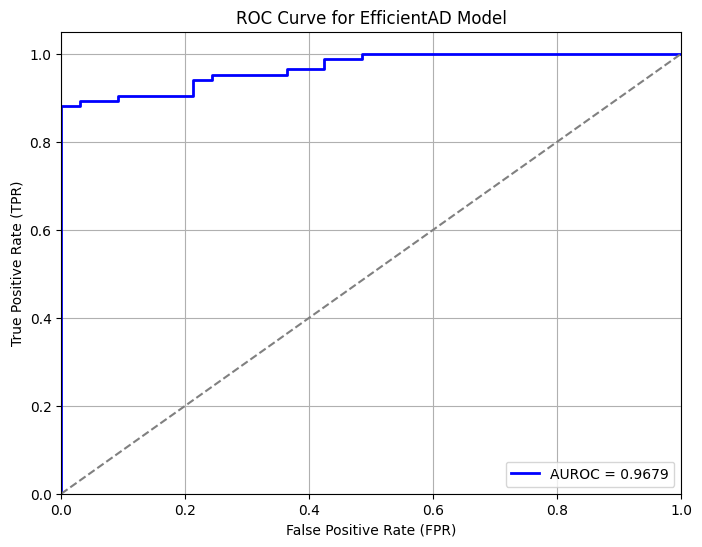

<Figure size 640x480 with 0 Axes>

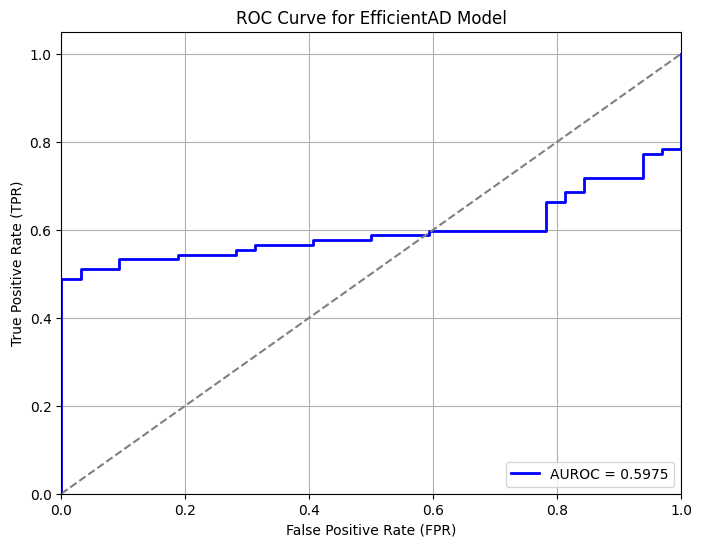

<Figure size 640x480 with 0 Axes>

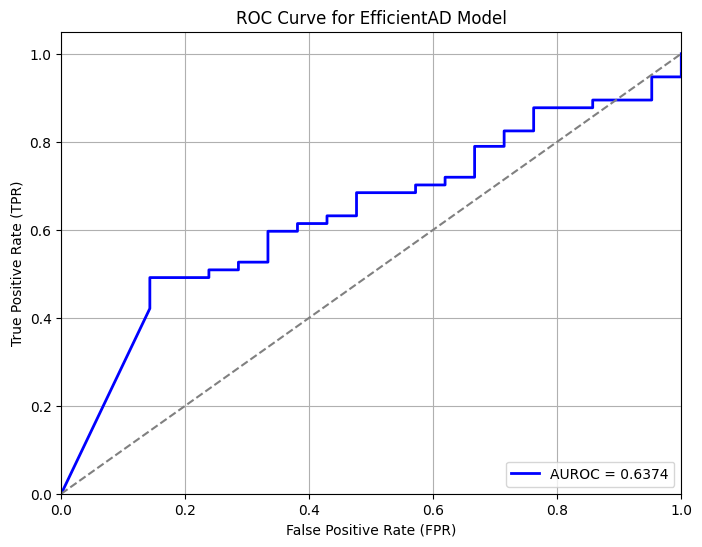

<Figure size 640x480 with 0 Axes>

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline

for cat in categories:
  y_true_tensor = torch.tensor(y_label[cat])
  y_scores_tensor = torch.tensor(y_score[cat])
  auroc_score = AUROC()(y_scores_tensor, y_true_tensor)
  fpr, tpr, _ = roc_curve(y_label[cat], y_score[cat])
  roc_auc = auc(fpr, tpr)
  # Plot ROC Curve
  plt.figure(figsize=(8, 6))
  plt.plot(fpr, tpr, color="blue", lw=2, label=f"AUROC = {roc_auc:.4f}")
  plt.plot([0, 1], [0, 1], color="gray", linestyle="--")  # Random chance line
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel("False Positive Rate (FPR)")
  plt.ylabel("True Positive Rate (TPR)")
  plt.title("ROC Curve for EfficientAD Model")
  plt.legend(loc="lower right")
  plt.grid()
  plt.show()
  plt.clf()

You can see that the performance of EfficientAd on these three categories is lower than PatchCore

In [20]:
for model_name in auroc_results.keys():
    avg_auroc = sum(auroc_results[model_name].values()) / len(auroc_results[model_name])
    auroc_results[model_name]["Average"] = avg_auroc
    print(f"{model_name} Average AUROC: {avg_auroc:.4f}")

EfficientAd Average AUROC: 0.7343


In [22]:
def show_image_and_mask(sample, index):
    """Show an image with a mask."""
    image = Image.open(sample.image_path[index])
    mask = ToPILImage()(sample.gt_mask[index].int()).convert("RGB")

    if image.size != mask.size:
        mask = mask.resize(image.size)

    return Image.fromarray(np.hstack((np.array(image), np.array(mask))))

# Visualize a sample from tile dataset
show_image_and_mask(data, index=0)

AttributeError: 'dict' object has no attribute 'image_path'